In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST

In [ ]:
## Create dataloader

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 128 # We use a small batch size here for training
batch_size_test = 128 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=False)

## Data Visualization

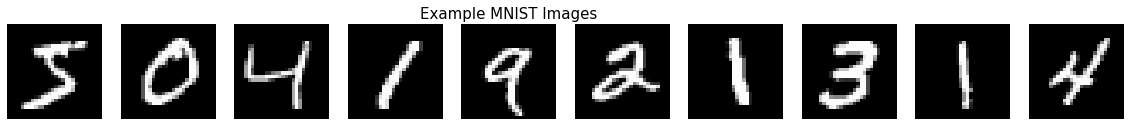

In [ ]:
## Data Visualization
images = train_dataset.data[:10]

plt.figure(figsize=(20,4))
for i in range(10):
  plt.subplot(1, 10, i+1)
  if i == 4:
    plt.title('Example MNIST Images', fontdict={'size': 15})
  plt.imshow(images[i].reshape(28, 28), cmap='gray')
  plt.axis('off')

## Build Convolutional Neural Network

<!-- Network Structure: -->
<!-- 
  Convolution(1, 32, 3)->BatchNorm(32)->ReLU()  
  ->Max Pooling(2)  
  ->Convolution(32, 64, 3)->BatchNorm(64)->ReLU()  
  ->Max Pooling(2)  
  ->Convolution(64, 128, 3)->BatchNorm(128)->ReLU()  
  ->GlobalAveragePooling(7)  
  ->Linear(128, 64)->ReLU()  
  ->Dropout(0.5)  
  ->Linear(64, 10) -->

In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.maxpool = nn.MaxPool2d(2)
        # self.gap = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64*49, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
from torchsummary import summary
model = CNN()
model.cuda()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                  [-1, 128]         401,536
           Linear-10                   [-1, 10]           1,290
Total params: 421,834
Trainable params: 421,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.93
Params size (MB): 1.61
Estimated T

## Training and Testing

In [ ]:
from tqdm import tqdm_notebook as tqdm

learning_rate = 1e-3
weight_decay = 5e-4
total_epochs = 10
decay_steps = [5]

Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_steps)

##define train function
def train(model, train_loader, optimizer, epoch, log_interval=10000):
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    loss_epoch = 0
    correct = 0
    total = 0

    model.train()    
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        correct += output.argmax(dim=1).eq(target).sum().item()
        total += target.shape[0]
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        loss_epoch += loss
        tk0.set_postfix(loss=loss_epoch.item()/(batch_idx+1), Acc=correct/total*100.)

    return (loss_epoch / (batch_idx+1)), 

##define test function
def test(model, test_loader):
    test_loss = 0
    correct = 0 

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += Loss(output, target)
            pred = output.argmax(dim=1) 
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= (len(test_loader.dataset)/batch_size_test)

    print('Testing, Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return (100. * correct / len(test_loader.dataset))

In [ ]:
trn_losses = []
test_accs = []

for epoch in range(1, total_epochs + 1):
    print('Epoch: {}/{}'.format(epoch, total_epochs))
    trn_losses.append(train(model, train_loader, optimizer, epoch))
    test_accs.append(test(model, test_loader))
    lr_scheduler.step()

Epoch: 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.1036, Accuracy: 9706/10000 (97.06%)

Epoch: 2/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0912, Accuracy: 9724/10000 (97.24%)

Epoch: 3/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0746, Accuracy: 9779/10000 (97.79%)

Epoch: 4/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0870, Accuracy: 9735/10000 (97.35%)

Epoch: 5/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0654, Accuracy: 9782/10000 (97.82%)

Epoch: 6/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0457, Accuracy: 9861/10000 (98.61%)

Epoch: 7/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0449, Accuracy: 9874/10000 (98.74%)

Epoch: 8/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0469, Accuracy: 9867/10000 (98.67%)

Epoch: 9/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0420, Accuracy: 9878/10000 (98.78%)

Epoch: 10/10


  0%|          | 0/468 [00:00<?, ?it/s]

Testing, Average loss: 0.0425, Accuracy: 9888/10000 (98.88%)



## Prediction Illustration

In [ ]:
for (img, label) in test_dataset:
  print(img.shape, label)

In [ ]:
correct_imgs = []
wrong_imgs = []
wrong_preds = []

model.eval()
with torch.no_grad():
    for img, label in test_dataset:
        img = img.cuda()
        output = model(img.unsqueeze(0))
        pred = output.argmax(dim=1) 
        if pred.item() == label:
          correct_imgs.append(img.detach().cpu().numpy())
        else:
          wrong_imgs.append(img.detach().cpu().numpy())
          wrong_preds.append(pred.item())

### Correctly predicted testing images

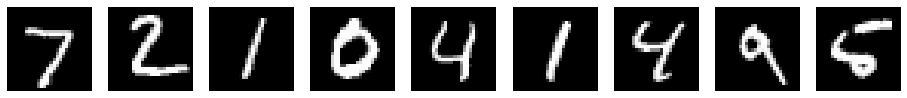

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(9):
  plt.subplot(1, 9, i+1)
  plt.imshow(correct_imgs[i][0], cmap='gray')
  plt.axis('off')

### Wrongly predicted testing images

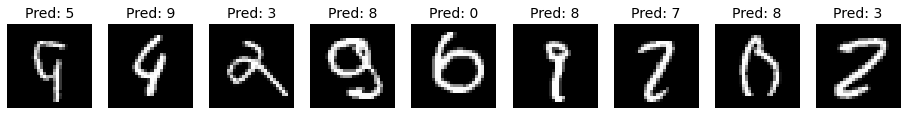

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(9):
  plt.subplot(1, 9, i+1)
  plt.imshow(wrong_imgs[i][0], cmap='gray')
  plt.axis('off')
  plt.title('Pred: {}'.format(wrong_preds[i]), fontdict={'size': 14})

## Filter Visualization

In [ ]:
filters1 = model.conv1.weight.detach().cpu().numpy()
filters2 = model.conv2.weight.detach().cpu().numpy()
print(filters1.shape)
print(filters2.shape)

(32, 1, 3, 3)
(64, 32, 3, 3)


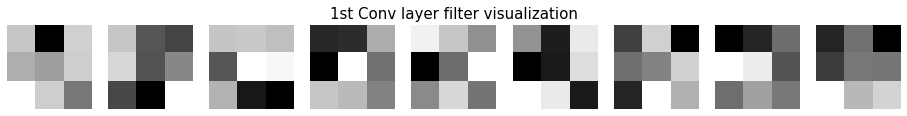

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(9):
  plt.subplot(1, 9, i+1)
  plt.imshow(filters1[i].reshape(3, 3), cmap='gray')
  plt.axis('off')
  if i == 4:
    plt.title('1st Conv layer filter visualization', fontdict={'size': 15})

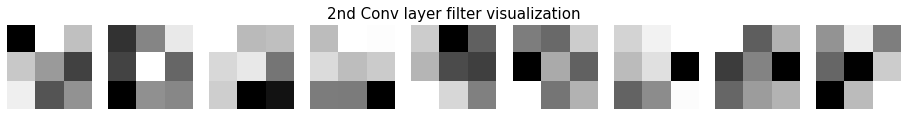

In [ ]:
plt.figure(figsize=(16, 4))
for i in range(9):
  plt.subplot(1, 9, i+1)
  plt.imshow(filters2[i, 0].reshape(3, 3), cmap='gray')
  plt.axis('off')
  if i == 4:
    plt.title('2nd Conv layer filter visualization', fontdict={'size': 15})